# Exercise 02-3: Preparation implementation

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='svg'

## Data preparation

We load the Iris data set from:

https://archive.ics.uci.edu/ml/datasets/iris

Since this data set has become the machine learning "Hello, World!"
equivalent, it is also part of many machine learning libraries. Have a look
at the Python module  `sklearn` submodule `datasets`, for example, which was
used
[here](https://gitlab.com/dirk-deckert-lmu/maml-ss20/-/blob/master/material/lec01/iris_plot.py)
to geenrate the Iris plot for the lecture notes.

Note that the column names are missing in the CSV file. They are described in
the accompanying file
https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.names.

In [2]:
file_name = 'iris_data_set.csv'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
column_names = ['sepal length [cm]', 'sepal width [cm]',
                'petal length [cm]', 'petal width [cm]', 'iris type']

if os.path.exists(file_name):
    print(f'Loading data from local file `{file_name}`...')
    df = pd.read_csv(file_name)
else:
    print(f'Loading data from `{url}`...')
    df = pd.read_csv(url, names=column_names)
    df.to_csv(file_name)
    print('Done.')

Loading data from `https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data`...
Done.


In [3]:

df['class'] = df['iris type'].replace(
    ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'],
    [-1, 1, 1])

and furthermore, shuffle the data:

In [4]:
def shuffle_df(df, training_data_fraction, random_state=None):
    '''
    Split all available data into a training and test data set.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame of available data.
    training_data_fraction : float
        The fraction of the data that should be used for training.
        E.g., `training_data_fraction=0.6` means 60%.
    random_state : int or numpy.random.RandomState, optional
        Allows to fix the seed for the pseudo-random numbers, 
        which is helpful for debugging in order to reproduce results.
    '''
    # first, we use the `sample()` function to select a fraction of the data
    # frame for the training data
    train_df = df.sample(frac=training_data_fraction, 
                         random_state=random_state)
    # second, we use the index of the just defined training data in the
    # function `drop()` that drops the respective entries from the data frame,
    # thus, leaving only the rest of the entries for our test data
    test_df = df.drop(train_df.index)
    return train_df, test_df

In [5]:
training_data_fraction = .8

train_df, test_df = shuffle_df(df, training_data_fraction)

# convert DataFrame entries to Numpy arrays
# `X, Y`: all data
# `train_X, train_Y`: training data
# `test_X, test_Y`: training data

X = df[['sepal length [cm]', 'sepal width [cm]']].to_numpy()
Y = df['class'].to_numpy()

train_X = train_df[['sepal length [cm]', 'sepal width [cm]']].to_numpy()
train_Y = train_df['class'].to_numpy()

test_X = test_df[['sepal length [cm]', 'sepal width [cm]']].to_numpy()
test_Y = test_df['class'].to_numpy()

print('Training data split as follows:')
print(f'  Training data samples: {len(train_df)}')
print(f'      Test data samples: {len(test_df)}')

Training data split as follows:
  Training data samples: 120
      Test data samples: 30


## Definition of the Perceptron model

Based on the previously define class for linear binary classification, which defined the hypothesis 
$h_{w,b}(x)=\text{sign}(w\cdot x+b)$ keeping track of the internal weight vector $w$ and bias term
$b$: 

In [6]:
class LinearBinaryClassification:

    def __init__(self, w, b):
        '''
        Initializes the model parameters.

        Parameters:
        -----------
        w : Array
            Numpy Array of correct dimension that specifies the weight row vector.
        b : float
            Bias term.
        '''
        self._w = w
        self._b = b

    def h(self, x):
        '''
        Evaluates the hypothesis corresponding to the given model parameters.

        Parameters
        ----------
        x : Array
            Array of correct dimension (transpose of the weight row vector).
        Returns
        -------
        Array of evaluations.

        '''
        # Numpy's `where` function provides a fast substitution even for larger
        # array
        return np.where(x @ self._w + self._b >= 0.0, 1, -1)

This class can now be used as follows:

we next derive from it a new class for the Perceptron that comprises the Perceptron algorithm in the `train()` method.

In [7]:
class Perceptron(LinearBinaryClassification):

    def __init__(self, w, b, eta):
        '''
        Initializes the model parameters.

        Parameters:
        -----------
        w : Array
            Array of correct dimension that specifies the weight row vector.
        b : float
            Bias term.
        eta: float
            Learning rate.
        '''
        self._eta = eta
        # this calls the constructor of the parent object, i.e., in this case of `LinearBinaryClassification`
        super().__init__(w, b)

    def train(self, X, Y, epochs=1):
        '''
        Executes the update rule for a certain number of epochs and adapts the internal
        model parameters to the Perceptron update rule.

        Parameters:
        -----------
        X : Array
            Array of feature vectors.
        Y : Array
            Array of class labels.
        epochs : int (optional)
            Number of epochs to train.
        '''
        for e in range(epochs):
            # Instead of randomly we traverse the array successively.
            # This should not make a big difference, if the array was shuffled before.
            errors = 0
            for xi, yi in zip(X, Y):
                # compute the $\Delta^{(i)}$ as in our lecture notes
                delta = yi - self.h(xi)
                # for simplicity we will always carry out the update rule
                # but note that `delta` will simply be zero if the
                # prediction was correct:
                self._w += self._eta * delta * xi.T
                self._b += self._eta * delta
                # count the number of errors
                errors += int(delta != 0)
            # the last few lines print an update every 10%
            progress = e * 100.0 / epochs
            if progress % 10 == 0:
                print(f'{progress:.2f}% of epochs finished. Current number of classification errors: {errors}')
        print('100%.')

In [10]:

# initial model parameters
w = np.array([0.0, 0.0])
b = 0.0
# elarning rate $\eta$
eta = 0.01

model = Perceptron(w, b, eta)

In [11]:
x = np.array([4, 5])

print(f'For given weight row vector w={w}, bias term b={b}, and argument vector x={x},\n'
      f'the hypothesis h evaluated at x equals {model.h(x)}.')

For given weight row vector w=[0. 0.], bias term b=0.0, and argument vector x=[4 5],
the hypothesis h evaluated at x equals 1.


Let us train the model for 100 epochs

In [12]:
model.train(train_X, train_Y, 10)

0.00% of epochs finished. Current number of classification errors: 17
10.00% of epochs finished. Current number of classification errors: 26
20.00% of epochs finished. Current number of classification errors: 15
30.00% of epochs finished. Current number of classification errors: 11
40.00% of epochs finished. Current number of classification errors: 9
50.00% of epochs finished. Current number of classification errors: 11
60.00% of epochs finished. Current number of classification errors: 2
70.00% of epochs finished. Current number of classification errors: 13
80.00% of epochs finished. Current number of classification errors: 2
90.00% of epochs finished. Current number of classification errors: 13
100%.


Note that the model hypothesis can still be accessed as before since `Perceptron` inherits this function from `LinearBinaryClassification`.

In [15]:
def plot_iris_decision_regions(model):

    # compute how large the mesh for the contour plot shall be (with +/- 1 as
    # safety bleed)
    x1_min = train_X[:, 0].min() - 1
    x1_max = train_X[:, 0].max() + 1
    x2_min = train_X[:, 1].min() - 1
    x2_max = train_X[:, 1].max() + 1

    # compute grid for contour plot
    x1_list, x2_list = np.meshgrid(np.arange(x1_min, x1_max, .01), 
                                np.arange(x2_min, x2_max, .01))
    # meshgrid produces two arrays of the size `len(np.arange(x1_min, x1_max,
    # .01))` times `len(np.arange(x2_min, x2_max, .01))` so that computations can
    # be easily be vectorized
    X_list = np.dstack([x1_list, x2_list])
    # present it our hypothesis for evaluation
    h_list = model.h(X_list)

    cmap = matplotlib.colors.ListedColormap(['red', 'blue'])
    plt.contourf(x1_list, x2_list, h_list, cmap=cmap, alpha=.3)

    train_X_minus1 = train_X[train_Y == -1]
    train_X_plus1 = train_X[train_Y == +1]

    plt.scatter(train_X_minus1[:, 0], train_X_minus1[:, 1], marker='x', color='red', label='Train: Iris-setosa', alpha=.7)
    plt.scatter(train_X_plus1[:, 0], train_X_plus1[:, 1], marker='x', color='blue', label='Train: other', alpha=.7)

    test_X_minus1 = test_X[test_Y == -1]
    test_X_plus1 = test_X[test_Y == +1]
    plt.scatter(test_X_minus1[:, 0], test_X_minus1[:, 1], marker='.', color='red', label='Test: Iris-setosa', alpha=.7)
    plt.scatter(test_X_plus1[:, 0], test_X_plus1[:, 1], marker='.', color='blue', label='Test: other', alpha=.7)

    plt.xlabel('sepal width [cm]')
    plt.xlim(x1_min, x1_max)
    plt.ylabel('sepal length [cm]')
    plt.ylim(x2_min, x2_max)
    plt.legend()

Let us plot the result. As we will do this twice, we define a helper function for the plotting:

### Count the number of errors in the classification of the training data

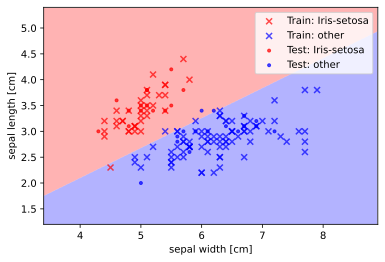

In [16]:
plot_iris_decision_regions(model)

Depending on your random seed, you might still see errors. If so, train again:

In [17]:
model.train(train_X, train_Y, 1000)

0.00% of epochs finished. Current number of classification errors: 4
10.00% of epochs finished. Current number of classification errors: 7
20.00% of epochs finished. Current number of classification errors: 2
30.00% of epochs finished. Current number of classification errors: 2
40.00% of epochs finished. Current number of classification errors: 0
50.00% of epochs finished. Current number of classification errors: 0
60.00% of epochs finished. Current number of classification errors: 0
70.00% of epochs finished. Current number of classification errors: 0
80.00% of epochs finished. Current number of classification errors: 0
90.00% of epochs finished. Current number of classification errors: 0
100%.


And plot again:

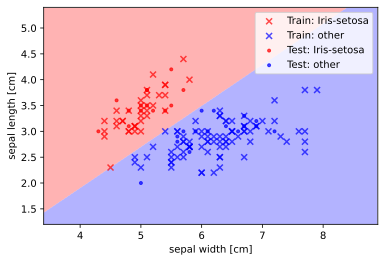

In [18]:
plot_iris_decision_regions(model)

In [19]:
N = len(train_X)
train_errors = np.sum(model.h(train_X).ravel() != train_Y)
print(f'Sample size: {N}')
print(f'Number of correct classifications: {N - train_errors}')
print(f'Number of incorrect classifications: {train_errors}')

Sample size: 120
Number of correct classifications: 120
Number of incorrect classifications: 0


### Compute the number of errors in predicting the classes of the test data

In [20]:
M = len(test_X)
test_errors = np.sum(model.h(test_X).ravel() != test_Y)
print(f'Sample size: {M}')
print(f'Number of correct classifications: {M - test_errors}')
print(f'Number of incorrect classifications: {test_errors}')

Sample size: 30
Number of correct classifications: 30
Number of incorrect classifications: 0


### And (redundantly) the total number of classification errors for training and test data altogether

In [22]:
total = len(X)
errors = np.sum(model.h(X).ravel() != Y)
print(f'Total sample size: {total}')
print(f'Number of correct classifications: {total - errors}')
print(f'Number of incorrect classifications: {errors}')

Total sample size: 150
Number of correct classifications: 150
Number of incorrect classifications: 0


To observe the learning behavior, adjust the initial model parameters 
and learning parameters and observe what happens during small number of epochs of updates.